<a href="https://colab.research.google.com/github/zhousanfu/tensorflow_demo/blob/master/tensorflow_textclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 需要模块

In [1]:
# !pip install -q tensorflow-datasets
# !pip install tensorflow
import tensorflow_datasets as tfds
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.preprocessing.sequence import  pad_sequences
import matplotlib.pyplot as plt
import pandas as pd
import io, time
from google.colab import drive
drive.mount('/content/drive')
# from sklearn.datasets.samples_generator import make_blobs
# from sklearn.preprocessing import MinMaxScaler

Mounted at /content/drive


## 1.1 数据预处理

In [25]:
# pd_all = pd.read_csv('tmp/imo_all.csv', sep='\t', encoding='utf-8')
pd_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/imo_bd_train.csv')
pd_all = shuffle(pd_all)
review_data, label_data = pd_all.review.replace(r'\n\t\r', '', regex=True), pd_all.label
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(review_data, label_data, test_size=0.1, shuffle=shuffle)
print(training_sentences.shape, training_labels.shape, testing_sentences.shape, testing_labels.shape)

training_sentences = [' '.join(str(x).replace('\n', '').replace('\r', '').replace(';', ' ').split()) for x in training_sentences.tolist()]
testing_sentences = [' '.join(str(x).replace('\n', '').replace('\r', '').replace(';', ' ').split()) for x in testing_sentences.tolist()]
training_labels = training_labels.tolist()
testing_labels = testing_labels.tolist()
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

(160142,) (160142,) (17794,) (17794,)


## 2.1 超参数设置

In [26]:
MAX_NB_WORDS = 10000 # 设置最频繁使用的XXX个词
MAX_SEQUENCE_LENGTH = 128 # 文本最大的长度
EMBEDDING_DIM = 16 # 设置Embeddingceng层的维度
TRUNC_TYPE = 'post'
OOV_TOK = '<oov>'

### 2.1.1 文字向量

In [27]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token=OOV_TOK)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating=TRUNC_TYPE)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=MAX_SEQUENCE_LENGTH)

## 2.2 定义模型
网络-损失函数和优化器

### 2.2.1 RNN

In [28]:
model = tf.keras.Sequential([
                tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
                tf.keras.layers.Flatten(),
                # tf.keras.layers.GlobalAveragePooling1D()
                tf.keras.layers.Dense(6, activation='relu'),
                tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 16)           160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 12294     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 172,301
Trainable params: 172,301
Non-trainable params: 0
_________________________________________________________________


In [29]:
num_epochs = 10

history = model.fit(
    training_padded,
    training_labels_final,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels_final),
    verbose=2
    )

Epoch 1/10
5005/5005 - 19s - loss: 0.2901 - accuracy: 0.8874 - val_loss: 0.2665 - val_accuracy: 0.8972
Epoch 2/10
5005/5005 - 18s - loss: 0.2420 - accuracy: 0.9056 - val_loss: 0.2655 - val_accuracy: 0.8987
Epoch 3/10
5005/5005 - 18s - loss: 0.2280 - accuracy: 0.9093 - val_loss: 0.2713 - val_accuracy: 0.8941
Epoch 4/10
5005/5005 - 18s - loss: 0.2170 - accuracy: 0.9128 - val_loss: 0.2713 - val_accuracy: 0.8956
Epoch 5/10
5005/5005 - 18s - loss: 0.2068 - accuracy: 0.9163 - val_loss: 0.2780 - val_accuracy: 0.8931
Epoch 6/10
5005/5005 - 18s - loss: 0.1977 - accuracy: 0.9197 - val_loss: 0.2889 - val_accuracy: 0.8924
Epoch 7/10
5005/5005 - 18s - loss: 0.1899 - accuracy: 0.9227 - val_loss: 0.3025 - val_accuracy: 0.8897
Epoch 8/10
5005/5005 - 18s - loss: 0.1834 - accuracy: 0.9248 - val_loss: 0.3210 - val_accuracy: 0.8895
Epoch 9/10
5005/5005 - 18s - loss: 0.1784 - accuracy: 0.9267 - val_loss: 0.3262 - val_accuracy: 0.8858
Epoch 10/10
5005/5005 - 18s - loss: 0.1740 - accuracy: 0.9278 - val_loss:

### 2.2.2 LSTM

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
epochs = 5
batch_size = 64
 
history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
    )

### 2.2.3 TF-Hub

In [ ]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

In [ ]:
import tensorflow_hub as hub
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=[], dtype=tf.string),
  embedding_layer,
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
])
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer="adam", metrics=['accuracy'])
model.summary()

In [ ]:
pd_all = pd.read_excel('tmp/imo_bd.xlsx', usecols=[1,0])
pd_all = shuffle(pd_all)
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(pd_all.review, pd_all.label, test_size=0.1, shuffle=shuffle)
training_sentences = [' '.join(str(x).replace('\n', '').replace('\r', '').replace(';', ' ').split()) for x in training_sentences.tolist()]
testing_sentences = [' '.join(str(x).replace('\n', '').replace('\r', '').replace(';', ' ').split()) for x in testing_sentences.tolist()]
# train_and_label = pd.DataFrame({'review':training_sentences, 'label':training_labels})
# test_and_label = pd.DataFrame({'review':testing_sentences, 'label':testing_labels})


train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_ds = train_ds.map(load_file).shuffle(5000)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)



train_and_label = tf.data.Dataset.from_tensor_slices((training_sentences, training_labels))
test_and_label = tf.data.Dataset.from_tensor_slices((testing_sentences, testing_labels))
print(train_and_label)
# <PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [ ]:
history = model.fit(
    (training_labels, training_labels),
    validation_data=(testing_sentences, testing_labels),
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)]
    )

## 3.1 loss可视化

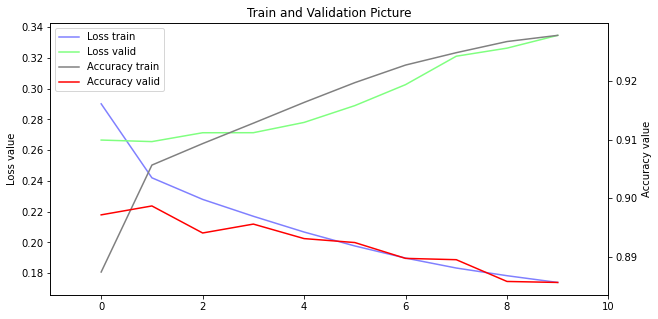

In [30]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(history.history['loss'], color=(0.5, 0.5, 1.0), label='Loss train')
line2, = ax1.plot(history.history['val_loss'], color=(0.5, 1.0, 0.5), label='Loss valid')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line3, = ax2.plot(history.history['accuracy'], color=(0.5, 0.5, 0.5), label='Accuracy train')
line4, = ax2.plot(history.history['val_accuracy'], color=(1, 0, 0), label='Accuracy valid')
plt.legend(handles=(line1, line2, line3, line4), loc='best')
plt.xlim(-1, 10)
plt.show()

## 3.2 向量反转

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
  return ' '.join([reverse_word_index.get(i, '0') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

## 3.3 模型保存

In [ ]:
# # 保存模型结构
# json_config = model.to_json()
# with open('model_config.json', 'w') as json_file:
#   json_file.write(json_config)

# ## HDF5 文件,单个二进制 blob，里面同时保存了模型权重、模型结构和优化器配置
# model.save_weights('path_to_my_weights.h5')

# SavedModel,使用 TensorFlow Serving 来部署模型时必须使用 SavedModel 格式
tf.keras.models.save_model(model, './saved_models/1')

# # checkpoint格式
# model.save_weights("xxx.ckpt", save_format="tf")

## 4.1 模型预测

In [31]:
class process_bar(object):
    def __init__(self, number=50, decimal=2):
        self.decimal = decimal
        self.number = number
        self.a = 100/number
 
    def __call__(self, now, total):
        percentage = self.percentage_number(now, total)
        well_num = int(percentage / self.a)
        progress_bar_num = self.progress_bar(well_num)
        result = "\r%s %s" % (progress_bar_num, percentage)
        return result
 
    def percentage_number(self, now, total):
        return round(now / total * 100, self.decimal)
 
    def progress_bar(self, num):
        well_num = "#" * num
        space_num = " " * (self.number - num)
        return '[%s%s]' % (well_num, space_num)

data = []
def predict_text(text_sent):
  global data
  text_sentences = tokenizer.texts_to_sequences(text_sent[2])
  my_text_padded = pad_sequences(text_sentences, maxlen=MAX_SEQUENCE_LENGTH)
  predictions_classify = model.predict_classes(my_text_padded) # model.predict_classes() 返回的是类别的索引，即该样本所属的类别标签
  if int(predictions_classify[0][0]) >= 1:
    predictions = model.predict(my_text_padded)
    data.append([text_sent[0],text_sent[1],text_sent[2],text_sent[3],text_sent[4],predictions_classify,predictions])
    print([text_sent[0],text_sent[1],text_sent[2],text_sent[3],text_sent[4],predictions_classify,predictions])

In [32]:
from multiprocessing import Pool


my_test_sentences = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/imo_con_0326_7.csv', usecols=[0,1,2,3,4]).values.tolist()

bar = process_bar()
pool = Pool(processes=500)
for sen in range(len(my_test_sentences)):
  pool.apply_async(predict_text, args=(my_test_sentences[sen]))
  print(bar(sen, len(my_test_sentences)), end='')
pool.close()
pool.join()

df = pd.DataFrame(data, columns=['day', 'opt_type', 'message', 'resource_id', 'comment_id', '标签(1=违规)', '得分'])
df.to_excel("预测.xlsx", index=False, sheet_name='Sheet1', encoding='utf-8')

[##################################################] 100.0